# Laboratorium 3

### Konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.added_points.append(PointsCollection())
         
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.added_lines.append(LinesCollection())

    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines = [], **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(callback.add_line)
        return [b_prev, b_next, b_add_point, b_add_line]
    
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes
        
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(self.callback)
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        


### Rozwiązanie

In [3]:
import math

eps = 10 ** (-14)

def removeVerticalLines(lines):
    for i in range(len(lines)):
        if isVertical(lines[i]):
            lines.pop(i)

def isVertical(line):
    if line[0][0] == line[1][0]:
        return True
    else:
        return False

def removeCloseLines(lines):
    for i in range(len(lines) - 1, -1, -1):
        if isClose(lines, i):
            lines.pop(i)
            
def isClose(lines, i):
    for j in range(len(lines)):
        if i == j:
            continue
        if dist(lines[j][0], lines[i][0]) < eps or dist(lines[j][0], lines[i][1]) < eps\
        or dist(lines[j][1], lines[i][0]) < eps or dist(lines[j][1], lines[i][1]) < eps:
            return True
    return False

def dist(A, B):
    dx = A[0] - B[0]
    dy = A[1] - B[1]
    return math.sqrt(dx * dx + dy * dy)

linesSets = [None, None]

### Interaktywne wprowadzanie odcinków

<IPython.core.display.Javascript object>


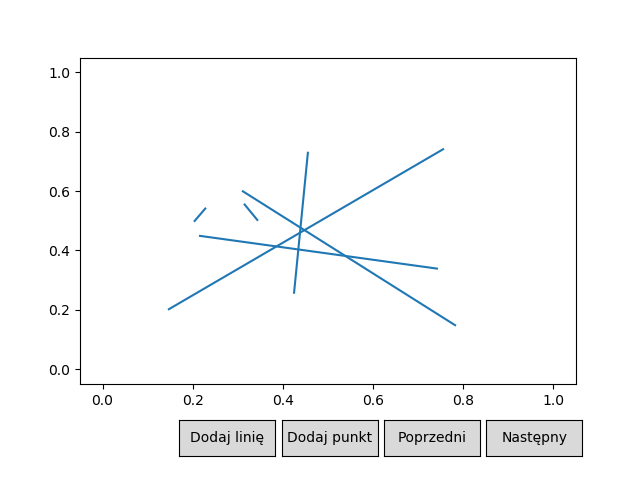

In [4]:
%matplotlib notebook
plot1 = Plot()
plot1.draw()

In [5]:
plot2 = Plot([plot1.get_added_elements()])
    
data = js.loads(plot2.toJson())
lines = []
if data and data[0] and data[0]["lines"]:
    for line in data[0]["lines"][0]:
        lines.append(line)
    
removeVerticalLines(lines)
removeCloseLines(lines)
linesSets[0] = lines
enScene = Scene([PointsCollection()], [LinesCollection([lines[i] for i in range(len(lines))], color = 'blue')])

# Zapis do pliku
# with open('enteredLines.json', 'w') as file:
#     file.write(Plot([enScene]).toJson())

### Generowanie losowych odcinków

In [6]:
import random

xmin = 0
ymin = 0
xmax = 10
ymax = 10
num = 30

lines = []
for i in range(num):
    while(True):
        A = [random.uniform(xmin, xmax), random.uniform(xmin, xmax)]
        B = [random.uniform(xmin, xmax), random.uniform(xmin, xmax)]
        lines.append([A, B])
        if isVertical(lines[i]) or isClose(lines, i):
            lines.pop(i)
        else:
            break

removeVerticalLines(lines)
removeCloseLines(lines)
linesSets[1] = lines
ranScene = Scene([PointsCollection()], [LinesCollection([lines[i] for i in range(len(lines))], color = 'green')])

# Zapis do pliku
# with open('generatedLines.json', 'w') as file:
#     file.write(Plot([ranScene]).toJson())

### Wizualizacja zbiorów odcinków

<IPython.core.display.Javascript object>


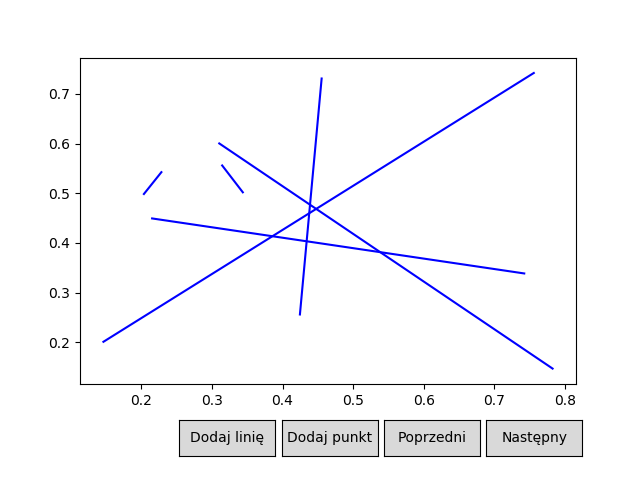

In [7]:
%matplotlib notebook

scenes = []
scenes.append(enScene)    
scenes.append(ranScene)

######### Ewentualne odczytanie z pliku ######################################################
# with open('lines.json', 'r') as file:
#     data = file.read()
# data = js.loads(data)
# lines = []
# for line in data[0]["lines"][0]:
#     lines.append(line)
    
# removeVerticalLines(lines)
# removeCloseLines(lines)
# linesSets.append(lines)
# fileScene = Scene([PointsCollection()], [LinesCollection([lines[i] for i in range(len(lines))], color = 'red')])
# scenes.append(fileScene)
###############################################################################################

plot = Plot(scenes)
plot.draw()

### Struktury danych

In [8]:
eps = 10 ** (-8)
#Struktura zdarzeń - kolejka priorytetowa
import heapq

#Struktura stanu - Drzewo RB, źródło: https://algorithmtutor.com/Data-Structures/Tree/Red-Black-Trees/
# Red Black Tree implementation in Python 2.7
# Author: Algorithm Tutor
# Tutorial URL: https://algorithmtutor.com/Data-Structures/Tree/Red-Black-Trees/

import sys

# data structure that represents a node in the tree
class Node():
    def __init__(self, data, name = -1):
        self.name = name
        self.data = data  # holds the key
        self.parent = None #pointer to the parent
        self.left = None # pointer to left child
        self.right = None #pointer to right child
        self.color = 1 # 1 . Red, 0 . Black


# class RedBlackTree implements the operations in Red Black Tree
class RedBlackTree():
    def __init__(self, a, b):
        self.a = a
        self.b = b
        self.TNULL = Node(0)
        self.TNULL.color = 0
        self.TNULL.left = None
        self.TNULL.right = None
        self.root = self.TNULL

    def __pre_order_helper(self, node):
        if node != TNULL:
            sys.stdout.write(node.data + " ")
            self.__pre_order_helper(node.left)
            self.__pre_order_helper(node.right)

    def __in_order_helper(self, node):
        if node != TNULL:
            self.__in_order_helper(node.left)
            sys.stdout.write(node.data + " ")
            self.__in_order_helper(node.right)

    def __post_order_helper(self, node):
        if node != TNULL:
            self.__post_order_helper(node.left)
            self.__post_order_helper(node.right)
            sys.stdout.write(node.data + " ")
    
    def __search_tree_helper(self, node, key, xs):
        node.data = self.a[node.name] * xs + self.b[node.name]
        if node == self.TNULL or key == node.data:
            return node

        if key < node.data - eps:
            return self.__search_tree_helper(node.left, key, xs)
        return self.__search_tree_helper(node.right, key, xs)

    # fix the rb tree modified by the delete operation
    def __fix_delete(self, x):
        while x != self.root and x.color == 0:
            if x == x.parent.left:
                s = x.parent.right
                if s.color == 1:
                    # case 3.1
                    s.color = 0
                    x.parent.color = 1
                    self.left_rotate(x.parent)
                    s = x.parent.right

                if s.left.color == 0 and s.right.color == 0:
                    # case 3.2
                    s.color = 1
                    x = x.parent
                else:
                    if s.right.color == 0:
                        # case 3.3
                        s.left.color = 0
                        s.color = 1
                        self.right_rotate(s)
                        s = x.parent.right

                    # case 3.4
                    s.color = x.parent.color
                    x.parent.color = 0
                    s.right.color = 0
                    self.left_rotate(x.parent)
                    x = self.root
            else:
                s = x.parent.left
                if s.color == 1:
                    # case 3.1
                    s.color = 0
                    x.parent.color = 1
                    self.right_rotate(x.parent)
                    s = x.parent.left

                if s.right.color == 0 and s.right.color == 0:
                    # case 3.2
                    s.color = 1
                    x = x.parent
                else:
                    if s.left.color == 0:
                        # case 3.3
                        s.right.color = 0
                        s.color = 1
                        self.left_rotate(s)
                        s = x.parent.left 

                    # case 3.4
                    s.color = x.parent.color
                    x.parent.color = 0
                    s.left.color = 0
                    self.right_rotate(x.parent)
                    x = self.root
        x.color = 0

    def __rb_transplant(self, u, v):
        if u.parent == None:
            self.root = v
        elif u == u.parent.left:
            u.parent.left = v
        else:
            u.parent.right = v
        v.parent = u.parent

    def __delete_node_helper(self, node, name, xs):
        # find the node containing key
        key = self.a[name] * xs + self.b[name]
        z = self.TNULL
        while node != self.TNULL:
            node.data = self.a[node.name] * xs + self.b[node.name]
            if node.data > key - eps and node.data < key + eps:
                z = node
                if z.name == name:
                    break

            if node.data < key:
                node = node.right
            else:
                node = node.left

        if z == self.TNULL:
            print ("Deletion: Couldn't find key in the tree")
            return

        y = z
        y_original_color = y.color
        if z.left == self.TNULL:
            x = z.right
            self.__rb_transplant(z, z.right)
        elif (z.right == self.TNULL):
            x = z.left
            self.__rb_transplant(z, z.left)
        else:
            y = self.minimum(z.right)
            y_original_color = y.color
            x = y.right
            if y.parent == z:
                x.parent = y
            else:
                self.__rb_transplant(y, y.right)
                y.right = z.right
                y.right.parent = y

            self.__rb_transplant(z, y)
            y.left = z.left
            y.left.parent = y
            y.color = z.color
        if y_original_color == 0:
            self.__fix_delete(x)
    
    # fix the red-black tree
    def  __fix_insert(self, k):
        while k.parent.color == 1:
            if k.parent == k.parent.parent.right:
                u = k.parent.parent.left # uncle
                if u.color == 1:
                    # case 3.1
                    u.color = 0
                    k.parent.color = 0
                    k.parent.parent.color = 1
                    k = k.parent.parent
                else:
                    if k == k.parent.left:
                        # case 3.2.2
                        k = k.parent
                        self.right_rotate(k)
                    # case 3.2.1
                    k.parent.color = 0
                    k.parent.parent.color = 1
                    self.left_rotate(k.parent.parent)
            else:
                u = k.parent.parent.right # uncle

                if u.color == 1:
                    # mirror case 3.1
                    u.color = 0
                    k.parent.color = 0
                    k.parent.parent.color = 1
                    k = k.parent.parent 
                else:
                    if k == k.parent.right:
                        # mirror case 3.2.2
                        k = k.parent
                        self.left_rotate(k)
                    # mirror case 3.2.1
                    k.parent.color = 0
                    k.parent.parent.color = 1
                    self.right_rotate(k.parent.parent)
            if k == self.root:
                break
        self.root.color = 0

    def __print_helper(self, node, indent, last):
        # print the tree structure on the screen
        if node != self.TNULL:
            sys.stdout.write(indent)
            if last:
                sys.stdout.write("R----")
                indent += "     "
            else:
                sys.stdout.write("L----")
                indent += "|    "

            s_color = "RED" if node.color == 1 else "BLACK"
            print (str(node.name) + " - data: " + str(node.data) + "(" + s_color + ")")
            self.__print_helper(node.left, indent, False)
            self.__print_helper(node.right, indent, True)
    
    # Pre-Order traversal
    # Node.Left Subtree.Right Subtree
    def preorder(self):
        self.__pre_order_helper(self.root)

    # In-Order traversal
    # left Subtree . Node . Right Subtree
    def inorder(self):
        self.__in_order_helper(self.root)

    # Post-Order traversal
    # Left Subtree . Right Subtree . Node
    def postorder(self):
        self.__post_order_helper(self.root)

    # search the tree for the key k
    # and return the corresponding node
    def searchTree(self, name, xs):
        k = self.a[name] * xs + self.b[name]
        return self.__search_tree_helper(self.root, k, xs)

    # find the node with the minimum key
    def minimum(self, node):
        while node.left != self.TNULL and node.left != None:
            node = node.left
        return node

    # find the node with the maximum key
    def maximum(self, node):
        while node.right != self.TNULL and node.left != None:
            node = node.right
        return node

    # find the successor of a given node
    def successor(self, x):
        # if the right subtree is not None,
        # the successor is the leftmost node in the
        # right subtree
        if x.right != self.TNULL and x.right != None:
            return self.minimum(x.right)

        # else it is the lowest ancestor of x whose
        # left child is also an ancestor of x.
        y = x.parent
        while y != self.TNULL and y != None and x == y.right:
            x = y
            y = y.parent
        return y

    # find the predecessor of a given node
    def predecessor(self,  x):
        # if the left subtree is not None,
        # the predecessor is the rightmost node in the 
        # left subtree
        if x.left != self.TNULL and x.left != None:
            return self.maximum(x.left)

        y = x.parent
        while y != self.TNULL and y != None and x == y.left:
            x = y
            y = y.parent

        return y

    # rotate left at node x
    def left_rotate(self, x):
        y = x.right
        x.right = y.left
        if y.left != self.TNULL:
            y.left.parent = x

        y.parent = x.parent
        if x.parent == None:
            self.root = y
        elif x == x.parent.left:
            x.parent.left = y
        else:
            x.parent.right = y
        y.left = x
        x.parent = y

    # rotate right at node x
    def right_rotate(self, x):
        y = x.left
        x.left = y.right
        if y.right != self.TNULL:
            y.right.parent = x

        y.parent = x.parent
        if x.parent == None:
            self.root = y
        elif x == x.parent.right:
            x.parent.right = y
        else:
            x.parent.left = y
        y.right = x
        x.parent = y

    # insert the key to the tree in its appropriate position
    # and fix the tree
    def insert(self, name, xs, add = 0):
        # Ordinary Binary Search Insertion
        key = self.a[name] * xs + self.b[name] + add
        node = Node(key, name)
        node.parent = None
        node.data = key
        node.left = self.TNULL
        node.right = self.TNULL
        node.color = 1 # new node must be red

        y = None
        x = self.root

        while x != self.TNULL:
            y = x
            x.data = self.a[x.name] * xs + self.b[x.name]
            if node.data < x.data:
                x = x.left
            else:
                x = x.right

        # y is parent of x
        node.parent = y
        if y == None:
            self.root = node
        elif node.data < y.data:
            y.left = node
        else:
            y.right = node

        # if new node is a root node, simply return
        if node.parent == None:
            node.color = 0
            return

        # if the grandparent is None, simply return
        if node.parent.parent == None:
            return

        # Fix the tree
        self.__fix_insert(node)

    def get_root(self):
        return self.root

    # delete the node from the tree
    def delete(self, name, xs):
        self.__delete_node_helper(self.root, name, xs)

    # print the tree structure on the screen
    def pretty_print(self):
        self.__print_helper(self.root, "", True)
        
    def content(self): ###
        return self.__content(self.root)
    
    def __content(self, node): ###
        if node != self.TNULL:
            return self.__content(node.left) + [node.name] + self.__content(node.right)
        else:
            return []
        
    def size(self): ###
        return len(self.content())

### Funkcje pomocnicze

In [9]:
eps = 10 ** (-8)

def det(A, B, C):
    return A[0]*B[1] + B[0]*C[1] + C[0]*A[1] - C[0]*B[1] - A[0]*C[1] - B[0]*A[1]

def orient(A, B, C):
    d = det(A, B, C)
    if d > eps:
        return 1
    elif d < -eps:
        return -1
    else:
        return 0
    
def onSegment(A, B, C):
    if orient(A, B, C) != 0:
        return false
    if C[0] <= max(A[0], B[0]) and C[0] >= min(A[0], B[0]) and C[1] <= max(A[1], B[1]) and C[1] >= min(A[1], B[1]):
        return true
    else:
        return false

def doIntersect(seg1, seg2):
    A = seg1[0]
    B = seg1[1]
    C = seg2[0]
    D = seg2[1]
    o1 = orient(A, B, C)
    o2 = orient(A, B, D)
    o3 = orient(C, D, A)
    o4 = orient(C, D, B)
    
    if o1 != o2 and o3 != o4:
        return True

    else:
        return False
    
def findIntersection(seg1, seg2):
    if not doIntersect(seg1, seg2):
        return 0
    
    A = seg1[0]
    B = seg1[1]
    C = seg2[0]
    D = seg2[1]
    
    a1 = (A[1] - B[1]) / (A[0] - B[0])
    b1 = A[1] - a1 * A[0]
    a2 = (C[1] - D[1]) / (C[0] - D[0])
    b2 = C[1] - a2 * C[0]

    x0 = (b2 - b1) / (a1 - a2)
    y0 = a1 * x0 + b1
    
    return [x0, y0]

def prepareLines(lines):
    for line in lines:
        A = line[0]
        B = line[1]
        if line[0][0] > line[1][0]:
            (line[0], line[1]) = (line[1], line[0])
            
def findSegs(lines):
    a = []
    b = []
    for line in lines:
        A = line[0]
        B = line[1]
        at = (A[1] - B[1]) / (A[0] - B[0])
        bt = A[1] - at * A[0]
        a.append(at)
        b.append(bt)
    return (a, b)
    
def findBorders(lines):
    ymax = lines[0][0][1]
    ymin = lines[0][0][1]
    for line in lines:
        for point in line:
            if ymax < point[1]:
                ymax = point[1]
            if ymin > point[1]:
                ymin = point[1]
    return (ymin, ymax)

def checkIfThereIs(P, points):
    for A in points:
        if abs(A[0] - P[0]) < eps and abs(A[1] - P[1]) < eps:
            return True

In [10]:
def handleEvent(T, i, xs, isStart):
    toCheck = []
    if isStart:
        T.insert(i, xs)
        node = T.searchTree(i, xs)
        succ = T.successor(node)
        pre = T.predecessor(node)
        if succ != None:
            toCheck.append([i, succ.name])
        if pre != None:
            toCheck.append([pre.name, i])
    else:
        node = T.searchTree(i, xs)
        succ = T.successor(node)
        pre = T.predecessor(node)
        T.delete(i, xs)
        if succ != None and pre != None:
            toCheck.append([pre.name, succ.name])
    return toCheck

def handleReplacement(T, i, j, xs):
    T.delete(i, xs)
    T.delete(j, xs)
    T.insert(i, xs)
    node = T.searchTree(i, xs)
    pre = T.predecessor(node)
    succ = T.successor(node)
    T.insert(j, xs, -eps)
    
    result = []
    if pre != None:
        result.append([pre.name, j])
    if succ != None:
        result.append([i, succ.name])
    return result

### Pierwszy algorytm zamiatania

In [11]:
# Algorytm sprawdzający, czy choć jedna para odcinków w zadanym zbiorze się przecina
# Wybór zbioru odcinków
lines = linesSets[0]

def doAnyIntersect(lines):
    prepareLines(lines)
    (a, b) = findSegs(lines)
    T = RedBlackTree(a, b)
    Q = []
    for i in range(len(lines)):
        A = lines[i][0]
        B = lines[i][1]
        heapq.heappush(Q, (A[0], i))
        heapq.heappush(Q, (B[0], i))

    while Q:
        (x, i) = heapq.heappop(Q)
        if x == lines[i][0][0]:
            C = lines[i][0]
            isStart = True
        else:
            C = lines[i][1]
            isStart = False
            
        toCheck = handleEvent(T, i, x, isStart)
        
        for el in toCheck:
            seg1 = lines[el[0]]
            seg2 = lines[el[1]]
            if doIntersect(seg1, seg2):
                print(findIntersection(seg1, seg2))
                return True
    return False

print(doAnyIntersect(lines))

[0.3857400315379487, 0.41360198746419485]
True


### Wizualizacja pierwszego algorytmu zamiatania

<IPython.core.display.Javascript object>


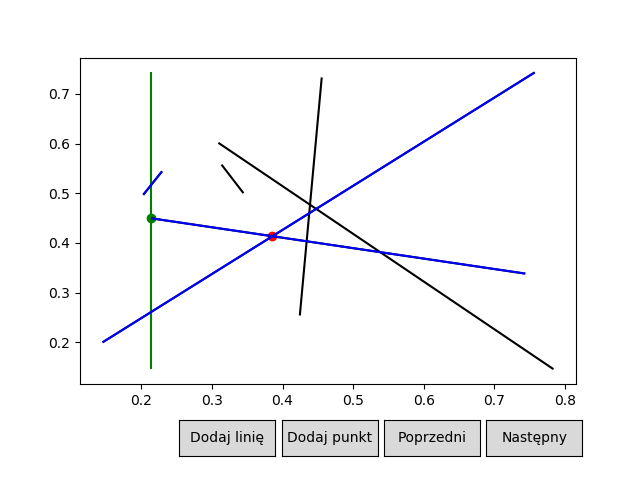

In [12]:
# Wybór zbioru odcinków
lines = linesSets[0]

scenes = []

def doAnyIntersectVis(lines):
    prepareLines(lines)
    if lines:
        (ymin, ymax) = findBorders(lines)
    
    scenes.append(Scene([PointsCollection()], [LinesCollection([lines[i] for i in range(len(lines))], color = 'black')]))
    
    (a, b) = findSegs(lines)
    T = RedBlackTree(a, b)
    Q = []
    for i in range(len(lines)):
        A = lines[i][0]
        B = lines[i][1]
        heapq.heappush(Q, (A[0], i))
        heapq.heappush(Q, (B[0], i))

    while Q:
        (x, i) = heapq.heappop(Q)
        if x == lines[i][0][0]:
            C = lines[i][0]
            isStart = True
        else:
            C = lines[i][1]
            isStart = False
            
        scenes.append(Scene([PointsCollection([C], color = 'green')], 
                            [LinesCollection([[[C[0], ymin], [C[0], ymax]]], color = 'green'),
                             LinesCollection([lines[i] for i in range(len(lines))], color = 'black')]))
                      
        toCheck = handleEvent(T, i, x, isStart)
        
        scenes.append(Scene([PointsCollection([C], color = 'green')], 
                            [LinesCollection([[[C[0], ymin], [C[0], ymax]]], color = 'green'),
                             LinesCollection([lines[i] for i in range(len(lines))], color = 'black'),
                             LinesCollection([lines[T.content()[i]] for i in range(T.size())], color = 'blue')]))
        
        for el in toCheck:
            seg1 = lines[el[0]]
            seg2 = lines[el[1]]
            if doIntersect(seg1, seg2):
                scenes.append(Scene([PointsCollection([C], color = 'green'),
                                     PointsCollection([findIntersection(seg1, seg2)], color = 'red')], 
                                    [LinesCollection([[[C[0], ymin], [C[0], ymax]]], color = 'green'),
                                     LinesCollection([lines[i] for i in range(len(lines))], color = 'black'),
                                     LinesCollection([lines[T.content()[i]] for i in range(T.size())], color = 'blue')]))
                return

doAnyIntersectVis(lines)
plot = Plot(scenes)
plot.draw()

### Pełny algorytm zamiatania

In [13]:
# Algorytm wyznaczający wszystkie przecięcia odcinków.
# Wybór zbioru odcinków
lines = linesSets[0]

def findIntersections(lines):
    prepareLines(lines)
    (a, b) = findSegs(lines)
    T = RedBlackTree(a, b)
    Q = []
    for i in range(len(lines)):
        A = lines[i][0]
        B = lines[i][1]
        heapq.heappush(Q, (A[0], i))
        heapq.heappush(Q, (B[0], i))
        
    result = []
    while Q:
        L = heapq.heappop(Q)
        if len(L) == 4:
            C = [0, 0]
            (C[0], C[1], i, j) = L
            toCheck = handleReplacement(T, i, j, C[0])
        else:
            (x, i) = L
            if x == lines[i][0][0]:
                C = lines[i][0]
                isStart = True
            else:
                C = lines[i][1]
                isStart = False
                
            toCheck = handleEvent(T, i, x, isStart)
            
        for el in toCheck:
            seg1 = lines[el[0]]
            seg2 = lines[el[1]]
            if doIntersect(seg1, seg2):
                P = findIntersection(seg1, seg2)
                if not checkIfThereIs(P, [result[i][0] for i in range(len(result))]):
                    heapq.heappush(Q, (P[0], P[1], el[0], el[1]))
                    result.append((P, el[0], el[1]))
    return result
                
#print(lines)
print(findIntersections(lines))

[([0.3857400315379487, 0.41360198746419485], 0, 2), ([0.5384530392947173, 0.38155969381107024], 2, 1), ([0.44771773854078295, 0.4685413764332105], 0, 1), ([0.4342093316297825, 0.4034321429334815], 5, 2), ([0.43786706321807345, 0.4598093644028678], 5, 0), ([0.43897721481561897, 0.4769203144462697], 5, 1)]


### Wizualizacja pełnego algorytmu zamiatania

<IPython.core.display.Javascript object>


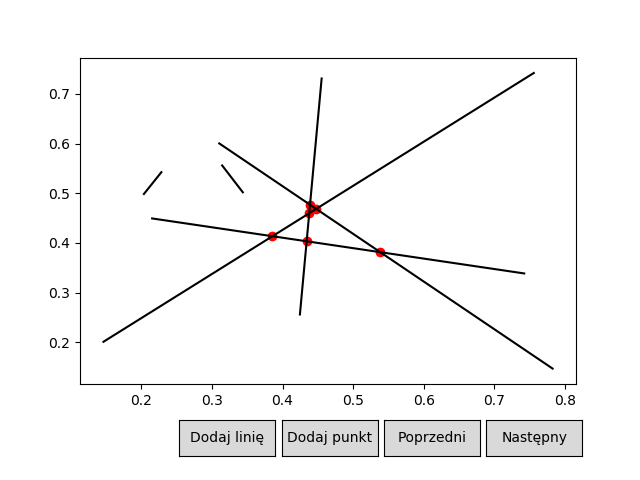

In [14]:
# Wybór zbioru odcinków
lines = linesSets[0]

scenes = []

def findIntersectionsVis(lines):
    prepareLines(lines)
    if lines:
        (ymin, ymax) = findBorders(lines)
    
    scenes.append(Scene([PointsCollection()], [LinesCollection([lines[i] for i in range(len(lines))], color = 'black')]))
    
    (a, b) = findSegs(lines)
    T = RedBlackTree(a, b)
    Q = []
    for i in range(len(lines)):
        A = lines[i][0]
        B = lines[i][1]
        heapq.heappush(Q, (A[0], i))
        heapq.heappush(Q, (B[0], i))
        
    result = []
    while Q:
        L = heapq.heappop(Q)
        if len(L) == 4:
            C = [0, 0]
            (C[0], C[1], i, j) = L
            toCheck = handleReplacement(T, i, j, C[0])

            scenes.append(Scene([PointsCollection([C], color = 'green'),
                                 PointsCollection([result[i][0] for i in range(len(result))], color = 'red')], 
                                [LinesCollection([[[C[0], ymin], [C[0], ymax]]], color = 'green'),
                                 LinesCollection([lines[i] for i in range(len(lines))], color = 'black')]))
            
        else:
            (x, i) = L
            if x == lines[i][0][0]:
                C = lines[i][0]
                isStart = True
            else:
                C = lines[i][1]
                isStart = False
                
            toCheck = handleEvent(T, i, x, isStart)
            
            scenes.append(Scene([PointsCollection([C], color = 'green'),
                                 PointsCollection([result[i][0] for i in range(len(result))], color = 'red')], 
                                [LinesCollection([[[C[0], ymin], [C[0], ymax]]], color = 'green'),
                                 LinesCollection([lines[i] for i in range(len(lines))], color = 'black')]))
            
        if Q:
            scenes.append(Scene([PointsCollection([C], color = 'green'),
                                 PointsCollection([result[i][0] for i in range(len(result))], color = 'red')], 
                                [LinesCollection([[[C[0], ymin], [C[0], ymax]]], color = 'green'),
                                 LinesCollection([lines[i] for i in range(len(lines))], color = 'black'),
                                 LinesCollection([lines[T.content()[i]] for i in range(T.size())], color = 'blue')]))
            
        for el in toCheck:
            seg1 = lines[el[0]]
            seg2 = lines[el[1]]
            if doIntersect(seg1, seg2):
                P = findIntersection(seg1, seg2)
                if not checkIfThereIs(P, [result[i][0] for i in range(len(result))]):
                    heapq.heappush(Q, (P[0], P[1], el[0], el[1]))
                    result.append((P, el[0], el[1]))
                    
                    scenes.append(Scene([PointsCollection([C], color = 'green'),
                                     PointsCollection([result[i][0] for i in range(len(result))], color = 'red'),
                                     PointsCollection([P], color = 'deeppink', marker = 's')], 
                                    [LinesCollection([[[C[0], ymin], [C[0], ymax]]], color = 'green'),
                                     LinesCollection([lines[i] for i in range(len(lines))], color = 'black'),
                                     LinesCollection([lines[T.content()[i]] for i in range(T.size())], color = 'blue')]))
                    
    scenes.append(Scene([PointsCollection([result[i][0] for i in range(len(result))], color = 'red')], 
                        [LinesCollection([lines[i] for i in range(len(lines))], color = 'black')]))
                    
findIntersectionsVis(lines)
plot = Plot(scenes)
plot.draw()